In [0]:
!pip install torch torchvision
# !pip3 install torch torchvision

In [0]:
mkdir results

mkdir: cannot create directory ‘results’: File exists


## Upload Old Models

In [0]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

KeyboardInterrupt: ignored

## Download Models From Drive

In [0]:
!cp "ckpt_normal.t70_0" checkpoint/ckpt_normal.t70_0
!cp "ckpt_adv.t70_0" checkpoint/ckpt_adv.t70_0

### Test Models

In [0]:
import argparse
import csv
import os

import numpy as np
import torch
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import sys
sys.path.append('cifar100')
import models
import cv2

import matplotlib.pyplot as plt

In [0]:
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4687, 0.4408), (0.2675, 0.2565, 0.2761)),
])

testset = datasets.CIFAR100(root='~/data', train=False, download=True,
                           transform=transform_test)

In [0]:
net = torch.load('checkpoint/ckpt_normal.t70_0')['net']
net.eval()

net_adv = torch.load('checkpoint/ckpt_adv.t70_0')['net']
net_adv.eval()

print ("Ready for eval")

Ready for eval


In [0]:
use_cuda = torch.cuda.is_available()
criterion = nn.CrossEntropyLoss()
epoch = 199

def accuracy(net):
  testloader = torch.utils.data.DataLoader(testset, batch_size=100,
                                         shuffle=False, num_workers=8)
  test_loss = 0.
  correct = 0.
  total = 0.
  
  correct_idxs = []
  
  for batch_idx, (inputs, targets) in enumerate(testloader):
    if use_cuda:
      inputs, targets = inputs.cuda(), targets.cuda()
      inputs, targets = Variable(inputs), Variable(targets)
      outputs = net(inputs)
      loss = criterion(outputs, targets)

      test_loss += loss.data.item()
      _, predicted = torch.max(outputs.data, 1)
      total += targets.size(0)
      correct += predicted.eq(targets.data).cpu().sum()
      
      correct_batch = predicted.eq(targets.data).cpu()
      for i in range(len(correct_batch)):
        if correct_batch[i] == 1:
          correct_idxs.append(batch_idx * 100 + i)
      acc = 100.*correct/total
  print (test_loss/batch_idx, (100.*correct/total).item())
  return correct_idxs

In [0]:
import torch 
torch.cuda.is_available()

False

In [0]:
print ("Normal")
accuracy(net)

print ("No Augment")
correct_no = accuracy(net_no)

#print ("Mixup")
#correct_mix = accuracy(net_mix)

print ("Horizontal")
correct_h = accuracy(net_h)

print ("Vertical")
correct_v = accuracy(net_v)

print ("Adversarial")
correct_adv = accuracy(net_adv)

Normal
(1.31772097072216, 74)
No Augment
(1.528210547837344, 67)
Mixup
(0.9905470838450422, 76)
Horizontal
(1.5477132255380803, 68)
Vertical
(1.3808140399480107, 72)
Adversarial
(2.104384411465038, 57)


In [0]:
inv_normalize = transforms.Normalize(
    mean=[-0.5071/0.2675, -0.4867/0.2565, -0.4408/0.2761],
    std=[1/0.2675, 1/0.2565, 1/0.2761]
)

In [0]:
pad_size = 16

def eval_horizontal_pad(net, pad_size = pad_size):
  testloader = torch.utils.data.DataLoader(testset, batch_size=100,
                                         shuffle=False, num_workers=8)
  accuracies = np.zeros(2 * pad_size)
  
  for batch_idx, (inputs, targets) in enumerate(testloader):
    if batch_idx % 10 == 0:
      print (batch_idx)
    mean = [0.5071, 0.4687, 0.4408]
    pad = np.tile(mean, [100, pad_size, 32, 1])
    pad = np.swapaxes(pad, 1, 3)
    padded = np.concatenate([pad, inputs, pad], 3)
    inputs = torch.FloatTensor(padded)
    inputs, targets = inputs.cuda(), targets.cuda()
    
    for i in range(2 * pad_size):
      inputs_part = inputs[:, :, :, i:i+32]
      outputs = net(inputs_part)
      _, predicted = torch.max(outputs.data, 1)
      correct = predicted.eq(targets.data).cpu()
      accuracies[i] += correct.sum()
      
  return accuracies

In [0]:
accuracies_adv = eval_horizontal_pad(net_adv)

0
10
20
30
40
50
60
70
80
90


In [0]:
accuracies = eval_horizontal_pad(net)

0
10
20
30
40
50
60
70
80
90


In [0]:
accuracies_no = eval_horizontal_pad(net_no)

0
10
20
30
40
50
60
70
80
90


In [0]:
accuracies_h = eval_horizontal_pad(net_h)
accuracies_v = eval_horizontal_pad(net_v)

0
10
20
30
40
50
60
70
80
90
0
10
20
30
40
50
60
70
80
90


In [0]:
#accuracies_mix = eval_horizontal_pad(net_mix)

0
10
20
30
40
50
60
70
80
90


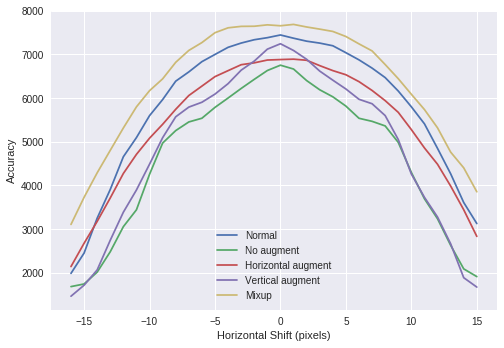

In [0]:
plt.plot(range(-pad_size, pad_size), accuracies, label='Normal')
plt.plot(range(-pad_size, pad_size), accuracies_no, label='No augment')
plt.plot(range(-pad_size, pad_size), accuracies_h, label='Horizontal augment')
plt.plot(range(-pad_size, pad_size), accuracies_v, label='Vertical augment')
plt.plot(range(-pad_size, pad_size), accuracies_mix, label='Mixup')
plt.legend()
plt.xlabel('Horizontal Shift (pixels)')
plt.ylabel('Accuracy')
plt.show()

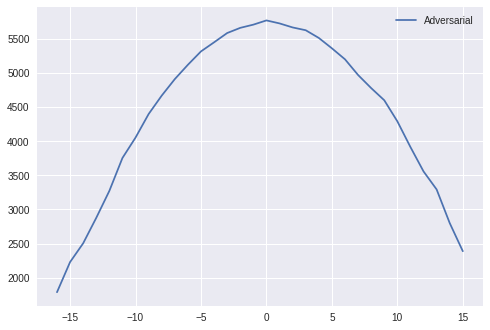

In [0]:
plt.plot(range(-pad_size, pad_size), accuracies_adv, label='Adversarial')
plt.legend()
plt.show()

In [0]:
pad_size = 16

def eval_vertical_pad(net, pad_size = pad_size):
  testloader = torch.utils.data.DataLoader(testset, batch_size=100,
                                         shuffle=False, num_workers=8)
  accuracies = np.zeros(2 * pad_size)
  
  for batch_idx, (inputs, targets) in enumerate(testloader):
    if batch_idx % 10 == 0:
      print (batch_idx)
    mean = [0.5071, 0.4687, 0.4408]
    pad = np.tile(mean, [100, 32, 16, 1])
    pad = np.swapaxes(pad, 1, 3)
    padded = np.concatenate([pad, inputs, pad], 2)
    inputs = torch.FloatTensor(padded)
    inputs, targets = inputs.cuda(), targets.cuda()
    
    for i in range(2 * pad_size):
      inputs_part = inputs[:, :, i:i+32, :]
      outputs = net(inputs_part)
      _, predicted = torch.max(outputs.data, 1)
      correct = predicted.eq(targets.data).cpu()
      accuracies[i] += correct.sum()
      
  return accuracies

In [0]:
accuracies = eval_vertical_pad(net)

0
10
20
30
40
50
60
70
80
90


In [0]:
accuracies_no = eval_vertical_pad(net_no)

0
10
20
30
40
50
60
70
80
90


In [0]:
accuracies_h = eval_vertical_pad(net_h)
accuracies_v = eval_vertical_pad(net_v)

0
10
20
30
40
50
60
70
80
90
0
10
20
30
40
50
60
70
80
90


In [0]:
accuracies_mix = eval_vertical_pad(net_mix)

0
10
20
30
40
50
60
70
80
90


In [0]:
accuracies_adv = eval_vertical_pad(net_adv)

0
10
20
30
40
50
60
70
80
90


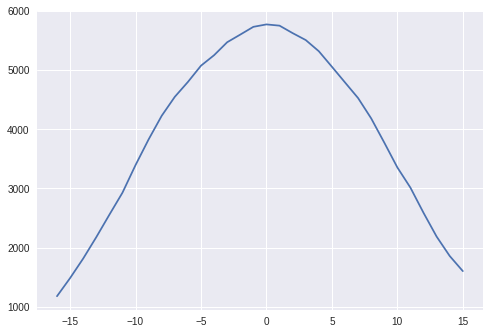

In [0]:
plt.plot(range(-pad_size, pad_size), accuracies_adv, label='Adversarial')

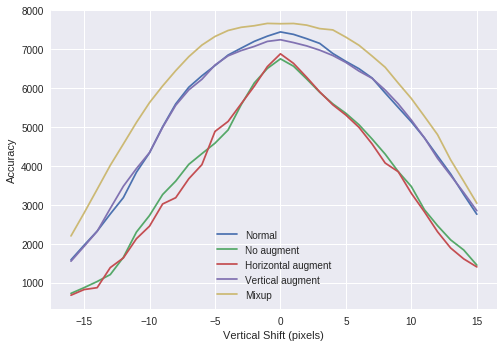

In [0]:
plt.plot(range(-pad_size, pad_size), accuracies, label='Normal')
plt.plot(range(-pad_size, pad_size), accuracies_no, label='No augment')
plt.plot(range(-pad_size, pad_size), accuracies_h, label='Horizontal augment')
plt.plot(range(-pad_size, pad_size), accuracies_v, label='Vertical augment')
plt.plot(range(-pad_size, pad_size), accuracies_mix, label='Mixup')
plt.legend()
plt.xlabel('Vertical Shift (pixels)')
plt.ylabel('Accuracy')
plt.show()

In [0]:
min_size = 1

def eval_resize(net, min_size = min_size):
  testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=8)

  accuracies = []
  true_classes = np.zeros((100, 2 * pad_size))
  for batch_idx, (inputs, targets) in enumerate(testloader):
    original = inputs.clone()
    inputs = inputs.cpu()
    for image_size in range(min_size, 33):
      input_images = np.ones((100,3,32,32))
      mask = np.ones((100,3,32,32))
      mask[:, :, :image_size, :image_size] = 0

      for j in range(inputs.shape[0]):
        part_of_image = 255 * (inv_normalize(torch.FloatTensor(inputs[j].clone())))
        resized = cv2.resize(part_of_image.numpy().T, (image_size, image_size), interpolation=cv2.INTER_LINEAR)
        empty = np.ones((3, 32, 32))
        empty[:, :image_size, :image_size] = resized.T
        part_of_mask = (mask[j, 0, :, :]).astype(np.uint8)

        image = cv2.inpaint(empty.astype(np.uint8).T, part_of_mask.T, 16, cv2.INPAINT_TELEA)
        image = image.astype(np.float64) / 255

        input_images[j] = np.swapaxes(transform_test(image), 1, 2)

      inputs_eval = torch.FloatTensor(input_images)
      inputs_eval, targets = inputs_eval.cuda(), targets.cuda()
      outputs = net(inputs_eval)
      loss = criterion(outputs, targets)
      outputs = torch.nn.functional.softmax(outputs, dim = 1)
      _, predicted = torch.max(outputs.data, 1)
      total = targets.size(0)
      correct = predicted.eq(targets.data).cpu().sum()

      acc = (100.*correct/total).item()
      accuracies.append(acc)
      
      true_class = outputs[np.arange(len(outputs)), targets]
      true_classes[:, image_size - 1] = true_class.detach().cpu()
    break
  return accuracies, true_classes

In [0]:
accuracies, true_classes = eval_resize(net)

Exception EOFError: EOFError() in <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7fc859781510>> ignored


In [0]:
accuracies_no, true_classes_no = eval_resize(net_no)

In [0]:
accuracies_h, true_classes_h = eval_resize(net_h)
accuracies_v, true_classes_v = eval_resize(net_v)

In [0]:
accuracies_mix, true_classes_mix = eval_resize(net_mix)

Text(0,0.5,u'Accuracy (%)')

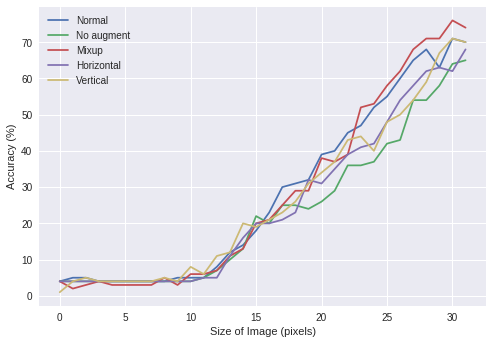

In [0]:
plt.plot(accuracies, label='Normal')
plt.plot(accuracies_no, label='No augment')
plt.plot(accuracies_mix, label='Mixup')
plt.plot(accuracies_h, label='Horizontal')
plt.plot(accuracies_v, label='Vertical')
plt.legend()
plt.xlabel('Size of Image (pixels)')
plt.ylabel('Accuracy (%)')

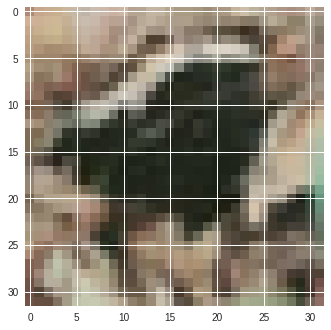

In [0]:
imgplot = plt.imshow(inv_normalize(original[7].cpu()).numpy().T)
plt.imshow(inv_normalize(inputs_eval[7].cpu()).numpy().T)

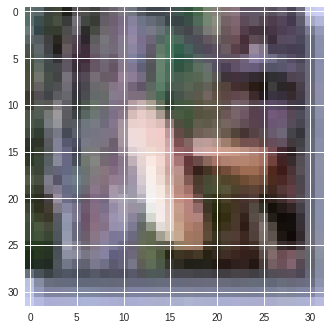

In [0]:
for batch_idx, (inputs, targets) in enumerate(testloader):
  image = inv_normalize(inputs[3]).numpy()
  np_image = np.swapaxes(image, 0, 2)
  plt.imshow((np_image))
  break